##### Copyright 2019-2021 Francois Lanusse.

Licensed under the Apache License, Version 2.0 (the "License");

# Generative Modeling of Galaxy Images

Author: [@EiffL](https://github.com/EiffL) (Francois Lanusse)
This adaptation comes from the python notebook available in 
https://github.com/EiffL/Tutorials/blob/master/GenerativeModels/GalaxyMorphologyVAE_solution.ipynb

### Overview

This tutorial aims to migrate the information corresponding to the model used in the article "Deep Generative Models for Galaxy Image Simulations" designed in TensorFlow 1.x to a more modern framework such as JAX.

In [1]:
from jax.lib import xla_bridge

#Checking for GPU access
print('Device: {}'.format(xla_bridge.get_backend().platform))

Device: gpu


In [1]:
import jax

# Checking the GPU available
gpus = jax.devices('gpu')
print(len(gpus))

3


## Importing the dataset

First of all, we need to read the data.

In [2]:
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds
import hsc_photoz

# Loading the dataset and transforming it to NumPy Arrays
train_dset, info = tfds.load(name="hsc_photoz", with_info=True, split='train')

2023-05-31 14:28:32.673088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/local/home/jt275011/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# What's in our dataset:
info;

Ok, we see that this dataset is a dictionary, field inputs are hsc cutouts in 5 bands (g,r,i,z,y), this will be the inputs to our CNN. We also see a specz_redshift entry, that will be our prediction target. Let's have a look at these.


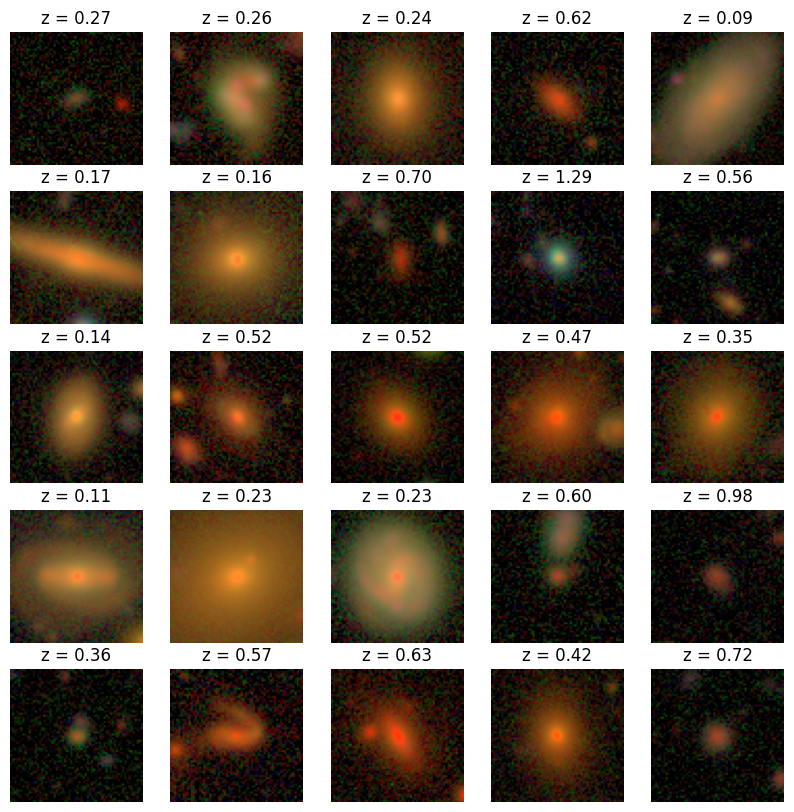

In [4]:
from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# The data is in 5 bands GRIZY, but for visualisation we use only the
# 3 first bands and luptonize them
def luptonize(img):
    return make_lupton_rgb(img[:,:,2], img[:,:,1], img[:,:,0],
                         Q=15, stretch=0.5, minimum=0)

plt.figure(figsize=(10,10))
for i, entry in enumerate(train_dset.take(25)):
    plt.subplot(5,5,i+1)
    plt.imshow(luptonize(entry['image']))
    plt.title('z = {:.2f}'.format(entry['attrs']['specz_redshift']))
    plt.axis('off')

Checking the distribution of the pixel values

In [5]:
# Let's collect a few examples to check their distributions
cutouts=[]
specz = []
for (batch, entry) in enumerate(train_dset.take(1000)):
    specz.append(entry['attrs']['specz_redshift'])
    cutouts.append(entry['image'])

cutouts = np.stack(cutouts)
specz = np.stack(specz)

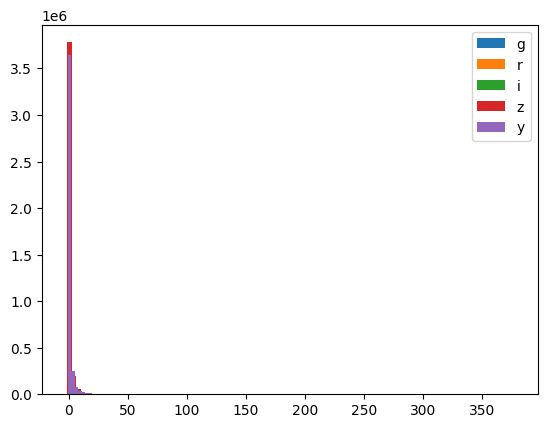

In [6]:
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
    plt.hist(cutouts[...,i].flatten(),100, label=b);
plt.legend();

As we can observe the pixel values are not standarized. In fact, they don't seem to follow a normal distribution. In order to facilitate data processing in the neural network, a good idea is to standardize the data.

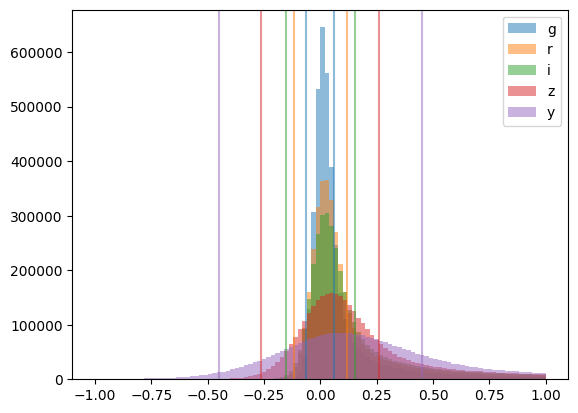

In [7]:
# Let's evaluate the noise standard deviation in each band, and apply range 
# compression accordingly
from astropy.stats import mad_std
scaling = []

for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
    plt.hist(cutouts[...,i].flatten(),100, label=b,alpha=0.5,range=[-1,1]);
    sigma = mad_std(cutouts[...,i].flatten()) # Capturing the std devation of each band
    scaling.append(sigma)
    plt.axvline(sigma, color='C%d'%i,alpha=0.5)
    plt.axvline(-sigma, color='C%d'%i,alpha=0.5)
plt.legend();

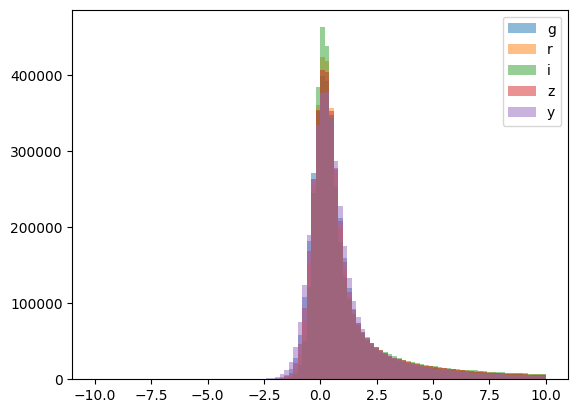

In [8]:
# Let's have a look at this distribution if we rescale each band by the standard
# deviation
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
    plt.hist(cutouts[...,i].flatten()/scaling[i],100, label=b,alpha=0.5,
           range=[-10,10]);
plt.legend();

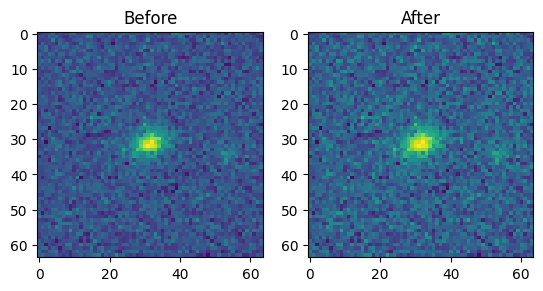

In [9]:
# we can have a look at individual postage stamps with or without this scaling
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cutouts[0,:,:,1]/scaling[1])
ax1.set_title('Before')
ax2.imshow(np.arcsinh(cutouts[0,:,:,1]/scaling[1]/3))
ax2.set_title('After');

Now that we have defined a scaling for the data that should be appropriate, we can build a scaling function and apply it to the dataset:

In [10]:
# Installing Weights & Biases
# !pip install -q wandb 

### Create the input pipeline

Now that we know how to preprocess the data, we can build the input pipeline. Below is a function that creates a Dataset object from the tfrecords files, decode them, applies preprocessing, shuffles the dataset, and create batches of data. Finally the function returns the dataset, that Flax models can directly ingest.

In [11]:
# Using a mapping function to apply preprocessing to our data
def preprocessing(example):
    img = tf.math.asinh(example['image'] / tf.constant(scaling) / 3. )
    # We return the image as our input and output for a generative model
    return img

def input_fn(mode='train', batch_size=64):
    """
    mode: 'train' or 'test'
    """
    if mode == 'train':
        dataset = tfds.load('hsc_photoz', split='train[:80%]')
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
    else:
        dataset = tfds.load('hsc_photoz', split='train[80%:]')
    
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(preprocessing) # Apply data preprocessing
    dataset = dataset.prefetch(-1) # fetch next batches while training current one (-1 for autotune)
    return dataset

In [12]:
dset = input_fn().as_numpy_iterator()

In [13]:
next(dset).shape

(64, 64, 64, 5)

In [14]:
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
from flax import linen as nn  # Linen API
from jax import random
from typing import Optional

tfd = tfp.distributions
tfb = tfp.bijectors

class probabilistic_encoder(nn.Module):
    """Creates a small convolutional encoder for the requested latent dimension."""
    latent_dim : int = 32
    
    @nn.compact
    def __call__(self, x):
    
        x = nn.Conv(features=32, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        # Image is now 32x32x32
        x = nn.Conv(features=64, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        # Image is now 16x16x64
        x = nn.Conv(features=128, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        # Image is now 8x8x128
        x = nn.Conv(features=256, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        # Image is now 4x4x256
        x = x.reshape((x.shape[0], -1))  # flatten
        # Densifying the network to arrive to the latent space
        x = nn.Dense(features=128)(x)
        x = nn.leaky_relu(x)
        
        return x

Testing the sizes of each layer of the CNN 

In [15]:
cnn = probabilistic_encoder()
print(cnn.tabulate(random.PRNGKey(0), jnp.ones((1, 64, 64, 5))))


                         probabilistic_encoder Summary                          
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path    ┃ module         ┃ inputs         ┃ outputs         ┃ params         ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│         │ probabilistic… │ float32[1,64,… │ float32[1,128]  │                │
├─────────┼────────────────┼────────────────┼─────────────────┼────────────────┤
│ Conv_0  │ Conv           │ float32[1,64,… │ float32[1,32,3… │ bias:          │
│         │                │                │                 │ float32[32]    │
│         │                │                │                 │ kernel:        │
│         │                │                │                 │ float32[3,3,5… │
│         │                │                │                 │                │
│         │                │                │                 │ 1,472 (5.9 KB) │
├─────────┼────────────────

Consruction of the VAE architecture

In [16]:
from absl import app
from absl import flags

# def del_all_flags(FLAGS):
#     flags_dict = FLAGS._flags()
#     keys_list = [keys for keys in flags_dict]
#     for keys in keys_list:
#         FLAGS.__delattr__(keys)

# del_all_flags(flags.FLAGS)
# FLAGS = flags.FLAGS

# flags.DEFINE_float(
#     'learning_rate', default=1e-3,
#     help=('The learning rate for the Adam optimizer.')
# )

# flags.DEFINE_integer(
#     'batch_size', default=64,
#     help=('Batch size for training.')
# )

# flags.DEFINE_integer(
#     'num_epochs', default=15,
#     help=('Number of training epochs.')
# )

# flags.DEFINE_integer(
#     'latent_dim', default=32,
#     help=('Dimension of latent space.')
# )

class probabilistic_encoder(nn.Module):
    """Creates a small convolutional encoder for the requested latent dimension."""
    latent_dim : int = 32
    
    # We choose a prior distribution for the latent codes
    # prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(latent_dim))

    @nn.compact
    def __call__(self, x):
        # First convolution layer
        x = nn.Conv(features=32, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        # Image is now 32x32x32
        x = nn.Conv(features=64, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        # Image is now 16x16x64
        x = nn.Conv(features=128, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        # Image is now 8x8x128
        x = nn.Conv(features=256, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        # Image is now 4x4x256
        x = x.reshape((x.shape[0], -1)) # flatten
        # Densifying the network to arrive to the latent space
        x = nn.Dense(features=128)(x)
        x = nn.leaky_relu(x)
        net = nn.Dense(features=self.latent_dim*2)(x)
        q = tfd.MultivariateNormalDiag(loc=net[:, :self.latent_dim], 
                               scale_diag=net[:, self.latent_dim:])
        return q

class probabilistic_decoder(nn.Module):
    """Creates a small convolutional decoder for the requested latent dimension."""
    
    @nn.compact
    def __call__(self, z):
        # Dense layer with the right size
        z = nn.Dense(features=4*4*256)(z)
        z = nn.leaky_relu(z)
        # Reshaping the layer
        z = z.reshape((-1, 4, 4, 256))
        # Image is now 4x4x256
        z = nn.ConvTranspose(features=128, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(z)
        z = nn.leaky_relu(z)
        # Image is now 8x8x128
        z = nn.ConvTranspose(features=64, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(z)
        z = nn.leaky_relu(z)
        # Image is now 16x16x64
        z = nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(z)
        z = nn.leaky_relu(z)
        # Image is now 32x32x32
        z = nn.ConvTranspose(features=5, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(z)
        z = nn.activation.softplus(z)
        # Image is now 64x64x5
        r =tfd.MultivariateNormalDiag(loc=z,
                                      scale_diag=[0.01, 0.01, 0.01, 0.01, 0.01])

        return r
    
class VAE(nn.Module):
    """Creates a variational autoencoder by using the two previous classes."""
    latent_dim : int = 32

    def setup(self):
        self.probabilistic_encoder = probabilistic_encoder(self.latent_dim)
        self.probabilistic_decoder = probabilistic_decoder()
        
    def __call__(self, x, seed):
        z = self.probabilistic_encoder(x)
        z = z.sample(seed=seed)
        recon_x = self.probabilistic_decoder(z)
        return recon_x
    

def model():
    return VAE(latent_dim=32)

@jax.jit
def init(key, x):
    variables_enc = model().init(key, x)
    return variables_enc['params']

# Generating a random key for JAX
rng = random.PRNGKey(0)
# Size of the input to initialize the parameters
batch_enc = jnp.ones((1, 64, 64, 5))

# Initializing the VAE
params = VAE().init(rng, batch_enc, rng)

# Taking 64 images of the dataset
batch_im = next(dset)
# Generating new keys to use them for inference
rng_1, rng_2 = random.split(rng)

# Applying the model to get the output probability distribution
batch_autoencoded = VAE().apply(params, batch_im, rng_1)

# Generating new keys to use them for sampling
rng_1, rng_2 = random.split(rng_2)
# Sampling over the output probability distribution
imgs_result = batch_autoencoded.sample(seed=rng_1)
# Verifying the shape of the output image
print(imgs_result.shape)

(64, 64, 64, 5)


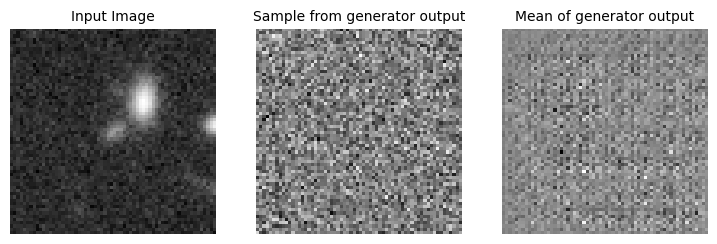

In [17]:
# we can have a look at individual postage stamps with or without this scaling
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,3))
ax1.imshow(batch_im[0,:,:,0],cmap='gray')
ax1.set_title('Input Image', fontsize=10)
ax1.axis('off')
ax2.imshow(batch_autoencoded.sample(seed=rng_1)[0,:,:,0],cmap='gray')
ax2.set_title('Sample from generator output', fontsize=10)
ax2.axis('off')
ax3.imshow(batch_autoencoded.mean()[0,:,:,0],cmap='gray')
ax3.set_title('Mean of generator output', fontsize=10)
ax3.axis('off');

In [18]:
# from flax.training import train_state
# 

# state = train_state.TrainState.create(
#       apply_fn=VAE().apply,
#       params=VAE().init(rng, batch_enc, rng)['params'],
#       tx=optax.adam(1e-3),
# )

In [19]:
# # Checking for the sizes of each layer
# dict_cnn = state.params._dict.items()
# for model, value in dict_cnn:
#     print(model)
#     for layer, values in value.items():
#         for key, data in values.items():
#             print('\t',layer, key, ':' , data.shape)
#     print('\n')


In [20]:
# Generating a random key for JAX
rng = random.PRNGKey(0)
# Size of the input to initialize the parameters
batch_enc = jnp.ones((1, 64, 64, 5))
# Initializing the VAE
params = VAE().init(rng, batch_enc, rng)

# Taking 64 images of the dataset
batch_im = next(dset)
# Generating new keys to use them for inference
rng_1, rng_2 = random.split(rng)

In [21]:
@jax.jit
def loss_fn(params, rng_key, batch): #state, rng_key, batch):
    
    x = batch

    # Autoencode an example
    q = VAE().apply(params, x, rng_key)

    # Compute loss
    kl = tfd.kl_divergence(q, tfd.MultivariateNormalDiag(jnp.zeros((1, 64, 64, 5))))
    log_likelihood = q.log_prob(x)

    elbo = log_likelihood - 0.0001*kl # Here we apply a regularization factor on the KL term
    loss = -elbo.mean()
    return loss

In [22]:
def lr_schedule(step):
    """Linear scaling rule optimized for 90 epochs."""
    steps_per_epoch = 40000 // 64 

    current_epoch = step / steps_per_epoch  # type: float
    boundaries = jnp.array((40, 80, 120)) * steps_per_epoch
    values = jnp.array([1., 0.1, 0.01, 0.001])

    index = jnp.sum(boundaries < step)
    return jnp.take(values, index)


In [23]:
import optax
optimizer = optax.chain(
      optax.adam(1e-3),
      optax.scale_by_schedule(lr_schedule))

opt_state = optimizer.init(params)

In [24]:
@jax.jit
def update(params, rng_key, opt_state, batch):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state 



In [25]:
# Utility function for tensoboard
from flax.metrics import tensorboard
import pickle

# To keep a log of training loss
step = 0
summary_writer = tensorboard.SummaryWriter("models/galsimjax")

In [26]:
import wandb
from flax.serialization import (
    to_state_dict, msgpack_serialize, from_bytes
)

wandb.login()

# Initializing a Weights & Biases Run
wandb.init(
    project="galsim-jax",
    name="first-model",
)

# Setting the configs of our experiment using `wandb.config`.
# This way, Weights & Biases automatcally syncs the configs of 
# our experiment which could be used to reproduce the results of an experiment.
config = wandb.config
config.seed = 42
config.batch_size = 64
# config.validation_split = 0.2
# config.pooling = "avg"
config.learning_rate = 1e-3
config.epochs = 25000

wandb: Currently logged in as: jonnyytorres. Use `wandb login --relogin` to force relogin


In [27]:
# def save_checkpoint(ckpt_path, state, epoch):
#     with open(ckpt_path, "wb") as outfile:
#         outfile.write(msgpack_serialize(to_state_dict(state)))
#     artifact = wandb.Artifact(
#         f'{wandb.run.name}-checkpoint', type='model'
#     )
#     artifact.add_file(ckpt_path)
#     wandb.log_artifact(artifact, aliases=["latest", f"epoch_{epoch}"])


# def load_checkpoint(ckpt_file, state):
#     artifact = wandb.use_artifact(
#         f'{wandb.run.name}-checkpoint:latest'
#     )
#     artifact_dir = artifact.download()
#     ckpt_path = os.path.join(artifact_dir, ckpt_file)
#     with open(ckpt_path, "rb") as data_file:
#         byte_data = data_file.read()
#     return from_bytes(state, byte_data)


# def accumulate_metrics(metrics):
#     metrics = jax.device_get(metrics)
#     return {
#         k: np.mean([metric[k] for metric in metrics])
#         for k in metrics[0]
#     }

In [28]:
from tqdm.auto import tqdm
losses = []
losses_test = []
losses_test_epoch = []
# best_eval_loss = 1e6

for epoch in tqdm(range(1, config.epochs + 1)):
    rng, rng_1 = random.split(rng)
    batch_im = next(dset)
    loss, params, opt_state = update(params, rng_1, opt_state, batch_im)
    losses.append(loss)
    step+=1
    
    # Log metrics inside your training loop to visualize model performance
    wandb.log({ 
        "loss": loss,
        }, step=epoch)
    
#     # Saving checkpoint
#     if loss < best_eval_loss:
#         best_eval_loss = loss
#         save_checkpoint("checkpoint.msgpack", opt_state, epoch)
    
    summary_writer.scalar('train_loss', loss, step)
    summary_writer.scalar('learning_rate', lr_schedule(step)*1e-3, step)
    if epoch % 2500 == 0 :
        # save_checkpoint("checkpoint.msgpack", opt_state, epoch)
        
        with open('models/galsimjax/model-%d.pckl'%epoch, 'wb') as file:
            pickle.dump([params, opt_state], file)
            
        dataset_eval = input_fn('test')
        test_iterator = dataset_eval.as_numpy_iterator()

        for_list_mean = []

        for img in test_iterator:
            rng, rng_1 = random.split(rng)
            loss_test = loss_fn(params, rng_1, img)
            for_list_mean.append(loss_test)

        losses_test.append(np.mean(for_list_mean))
        losses_test_epoch.append(epoch)
        
        wandb.log({ 
        "test_loss": losses_test[-1],
        }, step=epoch)
            
        print("Epoch: {}, loss: {:.2f}, loss test: {:.2f}".format(epoch, loss, losses_test[-1]))
            
loss_min = min(losses)
best_epoch = losses.index(loss_min)

print("\nBest Epoch: {}, loss: {:.2f}".format(best_epoch, loss_min))

 10%|███▊                                  | 2508/25000 [00:44<45:02,  8.32it/s]

Epoch: 2500, loss: 892.20, loss test: 989.83


 20%|███████▌                              | 5013/25000 [01:23<35:11,  9.47it/s]

Epoch: 5000, loss: 736.53, loss test: 763.70


 30%|███████████▍                          | 7514/25000 [02:01<31:16,  9.32it/s]

Epoch: 7500, loss: 754.17, loss test: 825.02


 40%|██████████████▊                      | 10009/25000 [02:39<24:19, 10.27it/s]

Epoch: 10000, loss: 797.24, loss test: 720.46


 50%|██████████████████▌                  | 12512/25000 [03:18<22:01,  9.45it/s]

Epoch: 12500, loss: 651.59, loss test: 714.75


 60%|██████████████████████▏              | 15013/25000 [03:56<16:19, 10.20it/s]

Epoch: 15000, loss: 708.53, loss test: 702.78


 70%|█████████████████████████▉           | 17507/25000 [04:34<14:09,  8.82it/s]

Epoch: 17500, loss: 708.23, loss test: 697.94


 80%|█████████████████████████████▌       | 20007/25000 [05:13<10:25,  7.98it/s]

Epoch: 20000, loss: 645.21, loss test: 697.12


 90%|█████████████████████████████████▎   | 22509/25000 [05:51<04:01, 10.32it/s]

Epoch: 22500, loss: 659.66, loss test: 719.75


100%|█████████████████████████████████████| 25000/25000 [06:29<00:00, 64.10it/s]

Epoch: 25000, loss: 654.80, loss test: 694.61



Best Epoch: 15018, loss: 566.13


In [29]:
wandb.finish()

loss,█▅▃▃▃▄▂▃▂▂▁▂▂▂▂▁▁▂▁▃▂▁▂▁▁▁▁▁▁▁▁▂▂▁▁▂▂▂▂▂
test_loss,█▃▄▂▁▁▁▁▂▁
loss,654.80096
test_loss,694.61359


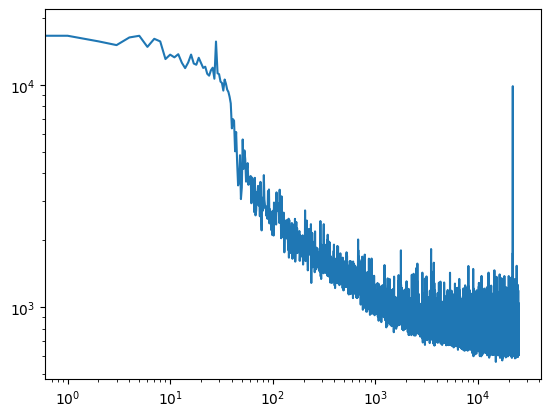

In [40]:
plt.loglog(losses);

In [41]:
losses_test_epoch

[2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000]

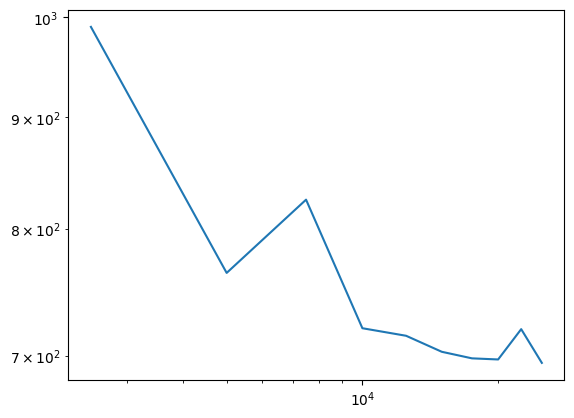

In [42]:
plt.loglog(losses_test_epoch, losses_test);

In [43]:
with open('models/galsimjax/model-{}.pckl'.format(config.epochs), 'wb') as file:
    pickle.dump([params, opt_state], file)

In [44]:
# # If I wanted to reload a specific outputed set of params I can use the following:
# with open('models/galsimjax/model-40000.pckl', 'rb') as file:
#     params, state, opt_state = pickle.load(, file)

In [45]:
# Retrieving a batch of data
batch = next(dset)

In [46]:
# Use the encoder to get the variational posterior distribution
x_distribution_post = VAE().apply(params, batch, rng_1)

In [47]:
# Sample some variables from the distribution
z = x_distribution_post.sample(seed=rng_1)

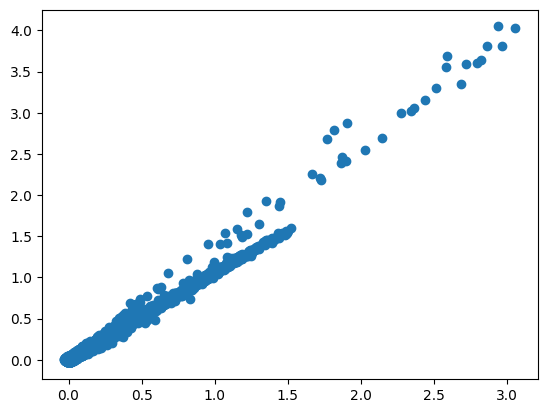

In [50]:
# Scatterplot of the x,y coordinates
plt.scatter(z[:,1], z[:,2]);

In [51]:
# Validating the output shape 
z.shape

(64, 64, 64, 5)

### Testing VAE auto-encoding

In [52]:
# Now that the model is 'trained', we can apply it
dataset_eval = input_fn('test')

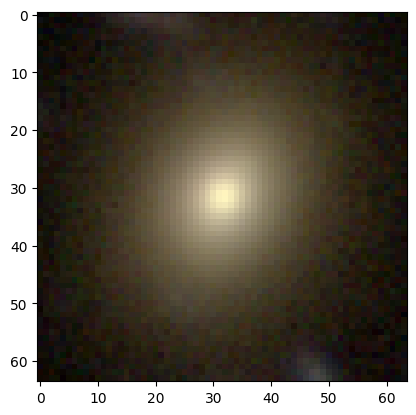

In [55]:
for batch_im in dataset_eval.take(1):
    # This extracts one batch of the test dset and shows the first example
    plt.imshow((batch_im[0,:,:,::-1][:,:,-3:]/batch_im[0,:,:,:3].numpy().max()));

In [56]:
autoencoded_im = VAE().apply(params, batch_im, rng_1) # Run the input batch through the model

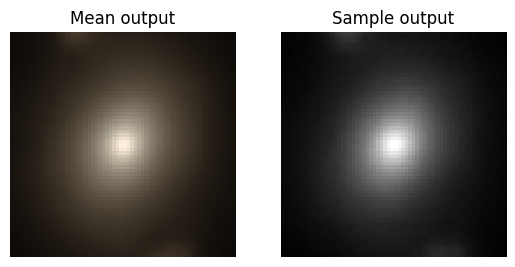

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2)
# Plot the mean of the output Multivariate Normal Diagonal distribution
ax1.imshow(autoencoded_im.mean()[0,:,:,-3:]/autoencoded_im.mean()[0,:,:,-3:].max(),cmap='gray')
ax1.set_title('Mean output')
ax1.axis('off')
# Plot a random sample of the output Multivariate Normal Diagonal distribution
ax2.imshow(autoencoded_im.sample(seed=rng_1)[0,:,:,0],cmap='gray')
ax2.set_title('Sample output')
ax2.axis('off');

### Sampling from the model

<Figure size 600x200 with 0 Axes>

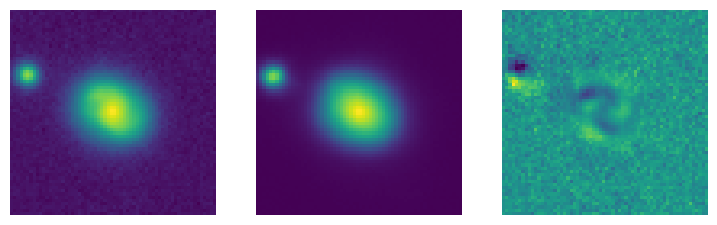

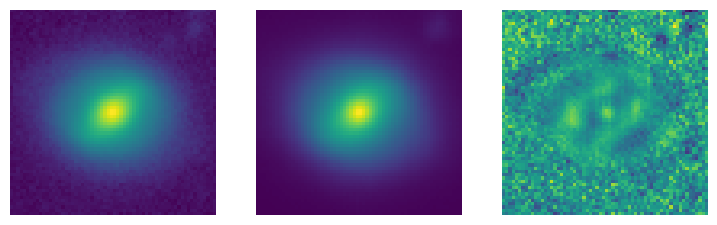

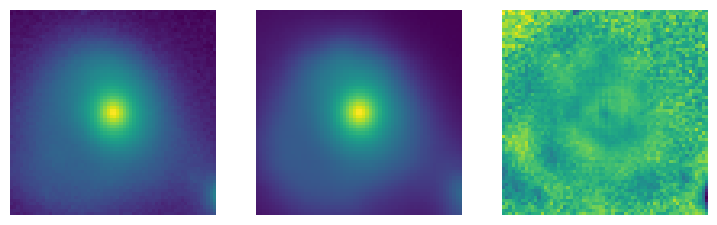

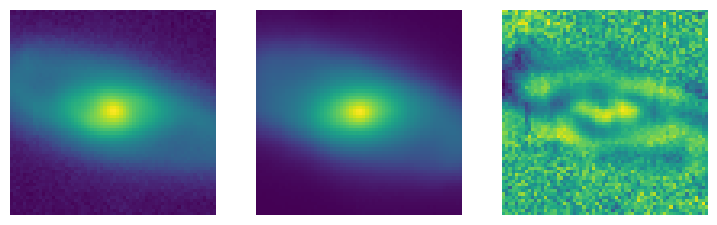

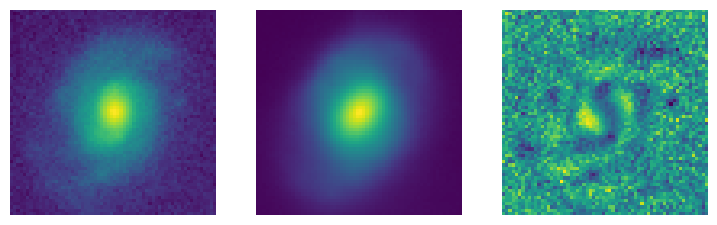

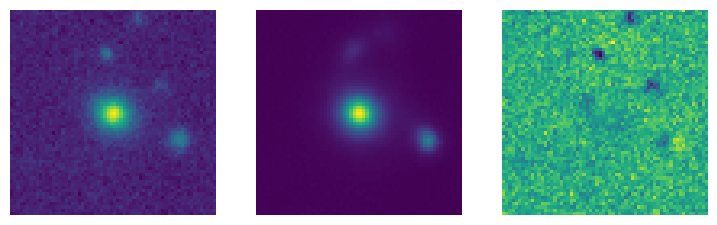

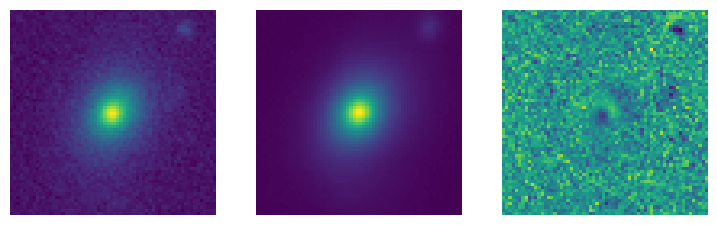

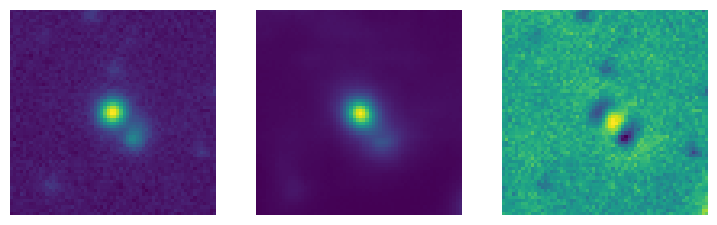

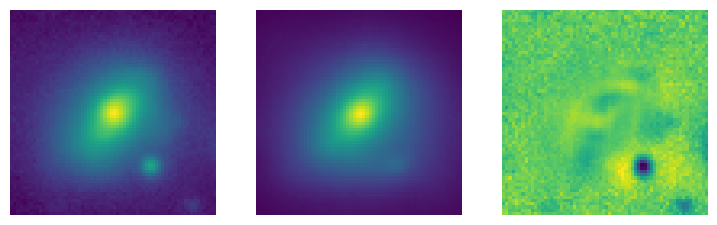

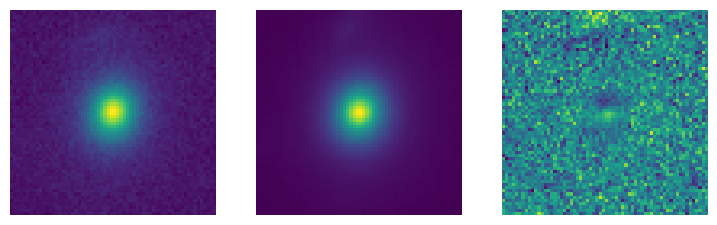

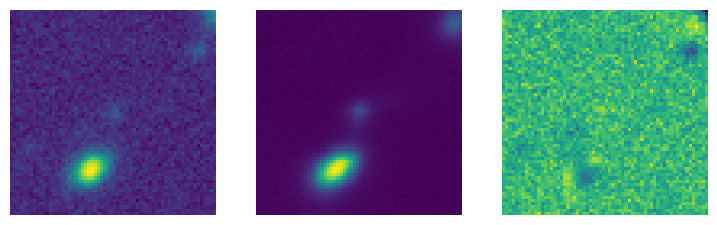

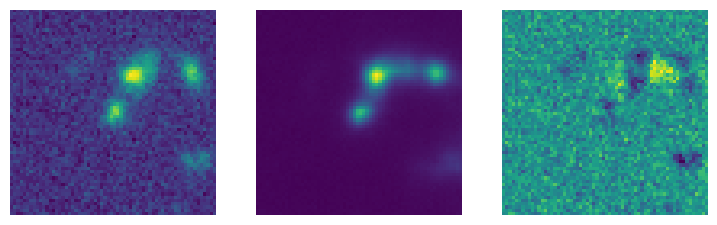

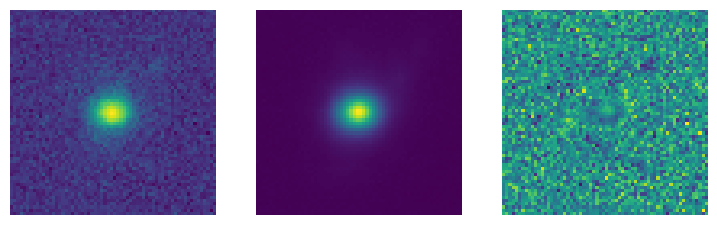

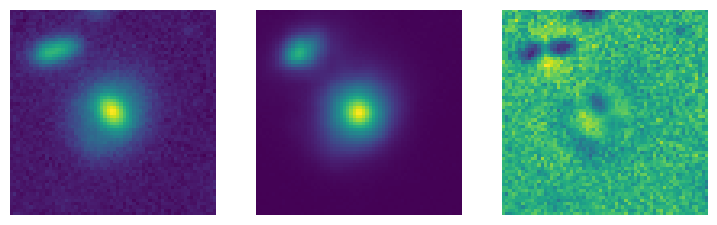

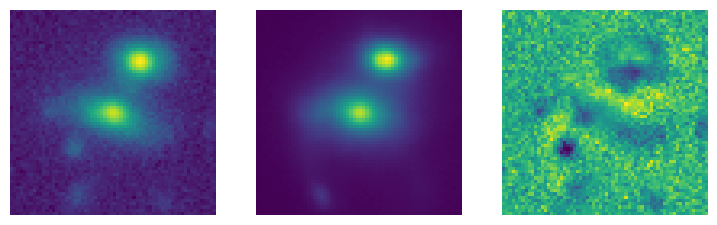

In [58]:
# Plotting the original and estimated image for 15 examples
plt.figure(figsize=(6,2));
for i in range(15):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,3));
    ax1.imshow(batch[i,:,:,:].mean(axis=-1))
    ax1.axis('off');
    ax2.imshow(z[i,:,:,:].mean(axis=-1))
    ax2.axis('off');
    ax3.imshow(z[i,:,:,:].mean(axis=-1) - batch[i,:,:,:].mean(axis=-1))
    ax3.axis('off');

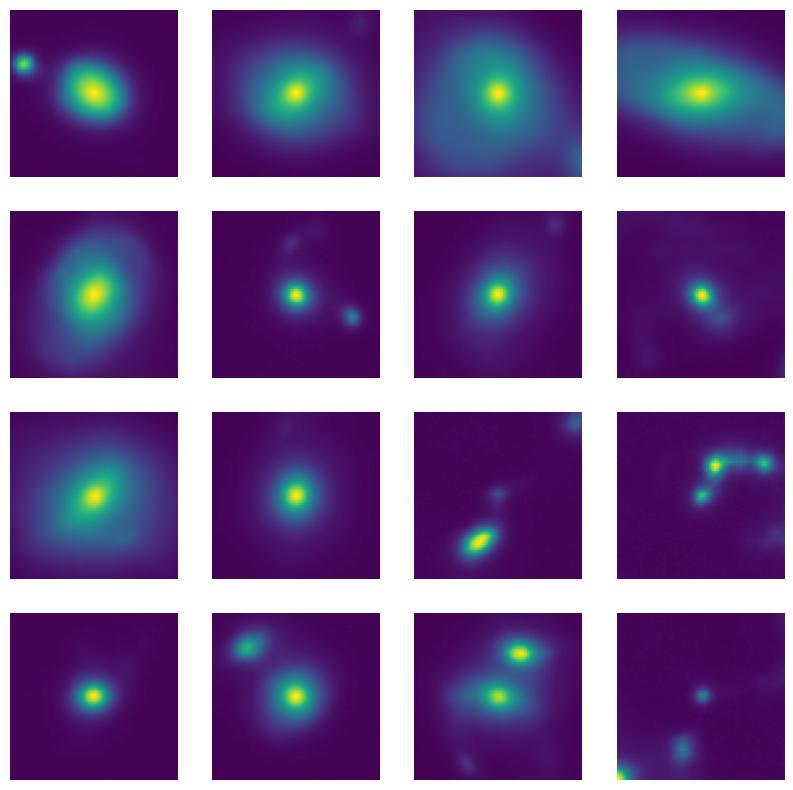

In [59]:
# 16 images of the estimated shape of galaxies
plt.figure(figsize=(10,10))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i+4*j+1)
        plt.imshow(z[i+4*j,:,:,:].mean(axis=-1))
        plt.axis('off');

In [60]:
# import jax.numpy as jnp
# from tensorflow_probability.substrates import jax as tfp
# from flax import linen as nn  # Linen API
# from jax import random
# from typing import Optional

# tfd = tfp.distributions
# tfb = tfp.bijectors

In [61]:
class ResNetBlock(nn.Module):
    act_fn : callable  # Activation function
    c_out : int   # Output feature size
    subsample : bool = False  # If True, we apply a stride inside F

    @nn.compact
    def __call__(self, x, train=True):
        # Network representing F
        print(x.shape)
        z = nn.Conv(self.c_out, kernel_size=(3, 3),
                    padding='SAME',
                    strides=(2, 2))(x)
        print(z.shape)
        z = self.act_fn(z)
        x = nn.Conv(self.c_out, kernel_size=(3, 3),
                    padding='SAME',
                    strides=(2, 2))(x)
        print(x.shape)
        x_out = self.act_fn(z + x)
        return x_out

In [62]:
class ResNetEnc(nn.Module):
    act_fn : callable
    block_class : nn.Module
    num_blocks : tuple = (1, 1, 1)
    c_hidden : tuple = (64, 128, 256)
    latent_dim : int = 32

    @nn.compact
    def __call__(self, x, train=True):
        # A first convolution on the original image to scale up the channel size
        print(x.shape)
        x = nn.Conv(self.latent_dim, kernel_size=(3, 3), padding='SAME', strides=(2, 2))(x)
        x = self.act_fn(x)
        print(x.shape)
        
        # Creating the ResNet blocks
        for block_idx, block_count in enumerate(self.num_blocks):
            for bc in range(block_count):
                # Subsample the first block of each group, except the very first one.
                subsample = (bc == 0 and block_idx > 0)
                # ResNet block
                x = self.block_class(c_out=self.c_hidden[block_idx],
                                     act_fn=self.act_fn,
                                     subsample=subsample)(x, train=train)

        # Mapping to classification output
        x = x.reshape((x.shape[0], -1)) # flatten
        print(x.shape)
        # Densifying the network to arrive to the latent space
        x = nn.Dense(features=128)(x)
        x = self.act_fn(x)
        print(x.shape)
        net = nn.Dense(features=self.latent_dim*2)(x)
        print(net.shape)
        q = tfd.MultivariateNormalDiag(loc=net[:, :self.latent_dim], 
                               scale_diag=net[:, self.latent_dim:])
        
        return q
    

In [63]:
res_net = ResNetEnc(act_fn=nn.leaky_relu, block_class=ResNetBlock)

# Generating a random key for JAX
rng = random.PRNGKey(0)
# Size of the input to initialize the parameters
batch_enc = jnp.ones((1, 64, 64, 5))
# Initializing the VAE
params = res_net.init(rng, batch_enc)

# Taking 64 images of the dataset
batch_im = next(dset)
# Generating new keys to use them for inference
rng_1, rng_2 = random.split(rng)

z = res_net.apply(params, batch_im)

print(z)

(1, 64, 64, 5)
(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 16, 16, 64)
(1, 16, 16, 64)
(1, 16, 16, 64)
(1, 8, 8, 128)
(1, 8, 8, 128)
(1, 8, 8, 128)
(1, 4, 4, 256)
(1, 4, 4, 256)
(1, 4096)
(1, 128)
(1, 64)
(64, 64, 64, 5)
(64, 32, 32, 32)
(64, 32, 32, 32)
(64, 16, 16, 64)
(64, 16, 16, 64)
(64, 16, 16, 64)
(64, 8, 8, 128)
(64, 8, 8, 128)
(64, 8, 8, 128)
(64, 4, 4, 256)
(64, 4, 4, 256)
(64, 4096)
(64, 128)
(64, 64)
tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[64], event_shape=[32], dtype=float32)


In [64]:
class ResNetBlockD(nn.Module):
    act_fn : callable  # Activation function
    c_out : int   # Output feature size
    subsample : bool = False  # If True, we apply a stride inside F

    @nn.compact
    def __call__(self, x, train=True):
        # Network representing F
        print(x.shape)
        z = nn.ConvTranspose(self.c_out, kernel_size=(3, 3),
                    padding='SAME',
                    strides=(2, 2))(x)
        print(z.shape)
        z = self.act_fn(z)
        x = nn.ConvTranspose(self.c_out, kernel_size=(3, 3),
                    padding='SAME',
                    strides=(2, 2))(x)
        print(x.shape)
        x_out = self.act_fn(z + x)
        return x_out

In [65]:
class ResNetDec(nn.Module):
    act_fn : callable
    block_class : nn.Module
    num_blocks : tuple = (1, 1, 1, 1)
    c_hidden : tuple = (128, 64, 32, 5)
    # num_channels : int = 5

    @nn.compact
    def __call__(self, x, train=True):
        # Dense layer with the right size
        x = nn.Dense(features=4*4*256)(x)
        x = self.act_fn(x)
        print(x.shape)
        # Reshaping the layer
        x = x.reshape((-1, 4, 4, 256))
        print(x.shape)
        
        
        # Creating the ResNet blocks
        for block_idx, block_count in enumerate(self.num_blocks):
            for bc in range(block_count):
                # Subsample the first block of each group, except the very first one.
                subsample = (bc == 0 and block_idx > 0)
                # ResNet block
                x = self.block_class(c_out=self.c_hidden[block_idx],
                                     act_fn=self.act_fn,
                                     subsample=subsample)(x, train=train)

        x = nn.activation.softplus(x)
        # Image is now 64x64x5
        r =tfd.MultivariateNormalDiag(loc=x,
                                      scale_diag=[0.01, 0.01, 0.01, 0.01, 0.01])

        return r

In [66]:
res_net_d = ResNetDec(act_fn=nn.leaky_relu, block_class=ResNetBlockD)

print(z)

# Generating a random key for JAX
rng = random.PRNGKey(0)

# Generating new keys to use them for inference
rng_1, rng_2 = random.split(rng)

code_sample = z.sample(seed=rng_2) 

# Size of the input to initialize the parameters
batch_enc = jnp.ones((1, 32))

# Initializing the resnet_dec
params = res_net_d.init(rng_2, batch_enc)

# Decoding the image
decoded_img = res_net_d.apply(params, code_sample)

print(decoded_img)

tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[64], event_shape=[32], dtype=float32)
(1, 4096)
(1, 4, 4, 256)
(1, 4, 4, 256)
(1, 8, 8, 128)
(1, 8, 8, 128)
(1, 8, 8, 128)
(1, 16, 16, 64)
(1, 16, 16, 64)
(1, 16, 16, 64)
(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 64, 64, 5)
(1, 64, 64, 5)
(64, 4096)
(64, 4, 4, 256)
(64, 4, 4, 256)
(64, 8, 8, 128)
(64, 8, 8, 128)
(64, 8, 8, 128)
(64, 16, 16, 64)
(64, 16, 16, 64)
(64, 16, 16, 64)
(64, 32, 32, 32)
(64, 32, 32, 32)
(64, 32, 32, 32)
(64, 64, 64, 5)
(64, 64, 64, 5)
tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[64, 64, 64], event_shape=[5], dtype=float32)


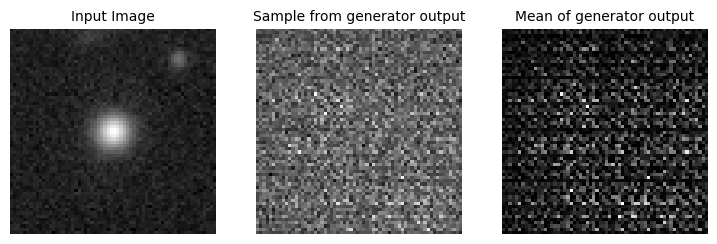

In [67]:
# we can have a look at individual postage stamps with or without this scaling
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,3))
ax1.imshow(batch_im[0,:,:,0],cmap='gray')
ax1.set_title('Input Image', fontsize=10)
ax1.axis('off')
ax2.imshow(decoded_img.sample(seed=random.PRNGKey(24))[0,:,:,0],cmap='gray')
ax2.set_title('Sample from generator output', fontsize=10)
ax2.axis('off')
ax3.imshow(decoded_img.mean()[0,:,:,0],cmap='gray')
ax3.set_title('Mean of generator output', fontsize=10)
ax3.axis('off');

In [68]:
# Generating a random key for JAX
rng = random.PRNGKey(0)
# Size of the input to initialize the parameters
batch_enc = jnp.ones((1, 64, 64, 5))
# Initializing the VAE
params_enc = ResNetEnc(act_fn=nn.leaky_relu, block_class=ResNetBlock).init(rng, batch_enc)

# Taking 64 images of the dataset
batch_im = next(dset)
# Generating new keys to use them for inference
rng, rng_1 = random.split(rng)

# Size of the input to initialize the parameters
batch_dec = jnp.ones((1, 32))

# Initializing the resnet_dec
params_dec = ResNetDec(act_fn=nn.leaky_relu, block_class=ResNetBlockD).init(rng, batch_dec)

(1, 64, 64, 5)
(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 16, 16, 64)
(1, 16, 16, 64)
(1, 16, 16, 64)
(1, 8, 8, 128)
(1, 8, 8, 128)
(1, 8, 8, 128)
(1, 4, 4, 256)
(1, 4, 4, 256)
(1, 4096)
(1, 128)
(1, 64)
(1, 4096)
(1, 4, 4, 256)
(1, 4, 4, 256)
(1, 8, 8, 128)
(1, 8, 8, 128)
(1, 8, 8, 128)
(1, 16, 16, 64)
(1, 16, 16, 64)
(1, 16, 16, 64)
(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 32, 32, 32)
(1, 64, 64, 5)
(1, 64, 64, 5)


In [69]:
@jax.jit
def loss_fn(params, rng_key, batch): #state, rng_key, batch):
    
    params_enc, params_dec = params
    
    x = batch

    # Autoencode an example
    q = ResNetEnc(act_fn=nn.leaky_relu, block_class=ResNetBlock).apply(params_enc, x)
    
    # Sample from the posterior
    z = q.sample(seed=rng_key)
    
    # Decode the sample
    p = ResNetDec(act_fn=nn.leaky_relu, block_class=ResNetBlockD).apply(params_dec, z)

    # Compute loss
    # kl = tfd.kl_divergence(p, tfd.MultivariateNormalDiag(jnp.zeros((1, 64, 64, 5))))
    log_likelihood = p.log_prob(x)

    elbo = log_likelihood #- 0.0001*kl # Here we apply a regularization factor on the KL term
    loss = -elbo.mean()
    return loss

In [70]:
# Defining a general list of the parameters
params = [params_enc, params_dec]
# Veryfing that the 'value_and_grad' works fine
loss, grads = jax.value_and_grad(loss_fn)(params, rng, batch_im)

(64, 64, 64, 5)
(64, 32, 32, 32)
(64, 32, 32, 32)
(64, 16, 16, 64)
(64, 16, 16, 64)
(64, 16, 16, 64)
(64, 8, 8, 128)
(64, 8, 8, 128)
(64, 8, 8, 128)
(64, 4, 4, 256)
(64, 4, 4, 256)
(64, 4096)
(64, 128)
(64, 64)
(64, 4096)
(64, 4, 4, 256)
(64, 4, 4, 256)
(64, 8, 8, 128)
(64, 8, 8, 128)
(64, 8, 8, 128)
(64, 16, 16, 64)
(64, 16, 16, 64)
(64, 16, 16, 64)
(64, 32, 32, 32)
(64, 32, 32, 32)
(64, 32, 32, 32)
(64, 64, 64, 5)
(64, 64, 64, 5)


In [71]:
# Veryfing the layers of the gradient (Decoder)
grads[1]['params'].keys()

frozen_dict_keys(['Dense_0', 'ResNetBlockD_0', 'ResNetBlockD_1', 'ResNetBlockD_2', 'ResNetBlockD_3'])

In [72]:
def lr_schedule(step):
    """Linear scaling rule optimized for 90 epochs."""
    steps_per_epoch = 40000 // 64 

    current_epoch = step / steps_per_epoch  # type: float
    boundaries = jnp.array((40, 80, 120)) * steps_per_epoch
    values = jnp.array([1., 0.1, 0.01, 0.001])

    index = jnp.sum(boundaries < step)
    return jnp.take(values, index)

In [73]:
import optax
optimizer = optax.chain(
      optax.adam(1e-3),
      optax.scale_by_schedule(lr_schedule))

opt_state = optimizer.init(params)

In [74]:
@jax.jit
def update(params, rng_key, opt_state, batch):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state 


In [75]:
loss, params, opt_state = update(params, rng, opt_state, batch_im)

In [76]:
# Utility function for tensoboard
from flax.metrics import tensorboard
import pickle

# To keep a log of training loss
step = 0
summary_writer = tensorboard.SummaryWriter("models/galsimjax_ResNet")

In [77]:
import wandb
from flax.serialization import (
    to_state_dict, msgpack_serialize, from_bytes
)

wandb.login()

# Initializing a Weights & Biases Run
wandb.init(
    project="galsim-jax-resnet",
    name="first-model",
)

# Setting the configs of our experiment using `wandb.config`.
# This way, Weights & Biases automatcally syncs the configs of 
# our experiment which could be used to reproduce the results of an experiment.
config = wandb.config
config.seed = 42
config.batch_size = 64
# config.validation_split = 0.2
# config.pooling = "avg"
config.learning_rate = 1e-3
config.epochs = 25000

In [78]:
from tqdm.auto import tqdm
losses = []
losses_test = []
losses_test_epoch = []
# best_eval_loss = 1e6

for epoch in tqdm(range(1, config.epochs + 1)):
    rng, rng_1 = random.split(rng)
    batch_im = next(dset)
    loss, params, opt_state = update(params, rng_1, opt_state, batch_im)
    losses.append(loss)
    step+=1
    
    # Log metrics inside your training loop to visualize model performance
    wandb.log({ 
        "loss": loss,
        }, step=epoch)
    
#     # Saving checkpoint
#     if loss < best_eval_loss:
#         best_eval_loss = loss
#         save_checkpoint("checkpoint.msgpack", opt_state, epoch)
    
    summary_writer.scalar('train_loss', loss, step)
    summary_writer.scalar('learning_rate', lr_schedule(step)*1e-3, step)
    if epoch % 2500 == 0 :
        # save_checkpoint("checkpoint.msgpack", opt_state, epoch)
        
        with open('models/galsimjax_ResNet/model-%d.pckl'%epoch, 'wb') as file:
            pickle.dump([params, opt_state], file)
            
        dataset_eval = input_fn('test')
        test_iterator = dataset_eval.as_numpy_iterator()

        for_list_mean = []

        for img in test_iterator:
            rng, rng_1 = random.split(rng)
            loss_test = loss_fn(params, rng_1, img)
            for_list_mean.append(loss_test)

        losses_test.append(np.mean(for_list_mean))
        losses_test_epoch.append(epoch)
        
        wandb.log({ 
        "test_loss": losses_test[-1],
        }, step=epoch)
            
        print("Epoch: {}, loss: {:.2f}, loss test: {:.2f}".format(epoch, loss, losses_test[-1]))
        
        
loss_min = min(losses)
best_epoch = losses.index(loss_min)

print("\nBest Epoch: {}, loss: {:.2f}".format(best_epoch, loss_min))

 10%|███▌                                | 2505/25000 [00:58<1:13:30,  5.10it/s]

Epoch: 2500, loss: 969.35, loss test: 1026.60


 20%|███████▌                              | 5005/25000 [01:57<57:54,  5.75it/s]

Epoch: 5000, loss: 1018.19, loss test: 860.29


 30%|███████████▍                          | 7505/25000 [02:55<45:16,  6.44it/s]

Epoch: 7500, loss: 727.45, loss test: 795.34


 40%|██████████████▊                      | 10005/25000 [03:54<44:00,  5.68it/s]

Epoch: 10000, loss: 717.70, loss test: 763.57


 50%|██████████████████▌                  | 12505/25000 [04:53<37:04,  5.62it/s]

Epoch: 12500, loss: 754.07, loss test: 750.51


 60%|██████████████████████▏              | 15005/25000 [05:53<25:24,  6.56it/s]

Epoch: 15000, loss: 735.88, loss test: 728.55


 70%|█████████████████████████▉           | 17505/25000 [06:51<17:05,  7.31it/s]

Epoch: 17500, loss: 680.06, loss test: 728.07


 80%|█████████████████████████████▌       | 20005/25000 [07:49<12:18,  6.76it/s]

Epoch: 20000, loss: 794.85, loss test: 727.85


 90%|█████████████████████████████████▎   | 22505/25000 [08:47<06:14,  6.65it/s]

Epoch: 22500, loss: 657.75, loss test: 710.40


100%|█████████████████████████████████████| 25000/25000 [09:45<00:00, 42.69it/s]

Epoch: 25000, loss: 653.88, loss test: 700.98



Best Epoch: 23997, loss: 590.18


In [79]:
wandb.finish()

loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,█▄▃▂▂▂▂▂▁▁
loss,653.87518
test_loss,700.98022


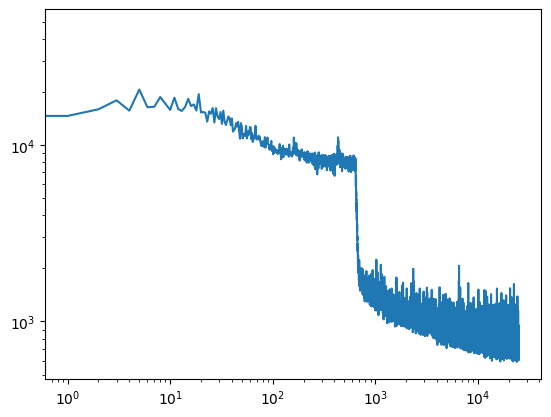

In [80]:
plt.loglog(losses);

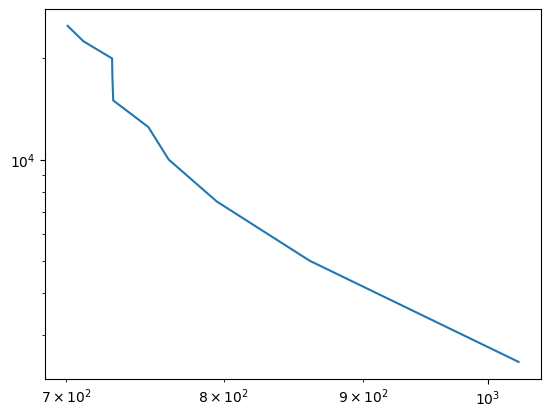

In [81]:
plt.loglog(losses_test, losses_test_epoch);

In [82]:
with open('models/galsimjax_ResNet/model-{}.pckl'.format(config.epochs), 'wb') as file:
    pickle.dump([params, opt_state], file)

In [83]:
# Retrieving a batch of data
batch = next(dset)

In [84]:
# Dividing the list of parameters obtained before
params_enc, params_dec = params
# Distribution of latent space calculated using the batch of data
q = ResNetEnc(act_fn=nn.leaky_relu, block_class=ResNetBlock).apply(params_enc, batch)
# Sampling from the distribution
z = q.sample(seed=rng)

# Posterior distribution
p = ResNetDec(act_fn=nn.leaky_relu, block_class=ResNetBlockD).apply(params_dec, z)
p

(64, 64, 64, 5)
(64, 32, 32, 32)
(64, 32, 32, 32)
(64, 16, 16, 64)
(64, 16, 16, 64)
(64, 16, 16, 64)
(64, 8, 8, 128)
(64, 8, 8, 128)
(64, 8, 8, 128)
(64, 4, 4, 256)
(64, 4, 4, 256)
(64, 4096)
(64, 128)
(64, 64)
(64, 4096)
(64, 4, 4, 256)
(64, 4, 4, 256)
(64, 8, 8, 128)
(64, 8, 8, 128)
(64, 8, 8, 128)
(64, 16, 16, 64)
(64, 16, 16, 64)
(64, 16, 16, 64)
(64, 32, 32, 32)
(64, 32, 32, 32)
(64, 32, 32, 32)
(64, 64, 64, 5)
(64, 64, 64, 5)


<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[64, 64, 64] event_shape=[5] dtype=float32>

In [85]:
# Sample some variables from the posterior distribution
z = p.sample(seed=rng)

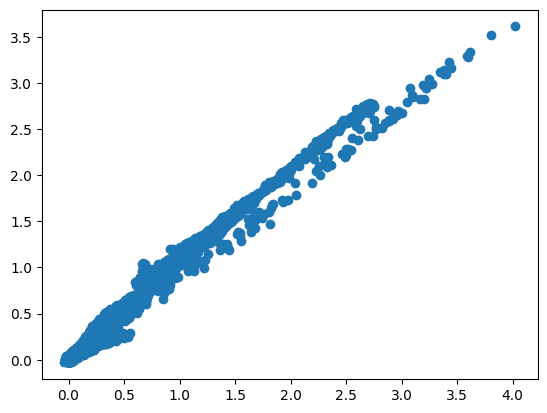

In [86]:
# Scatterplot of the x,y coordinates
plt.scatter(z[:,1], z[:,2]);

In [87]:
# Validating the output shape 
z.shape

(64, 64, 64, 5)

### Sampling from the model

<Figure size 600x200 with 0 Axes>

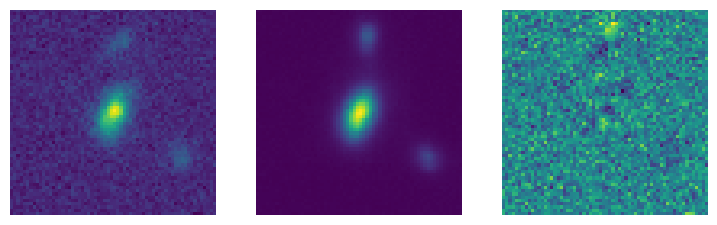

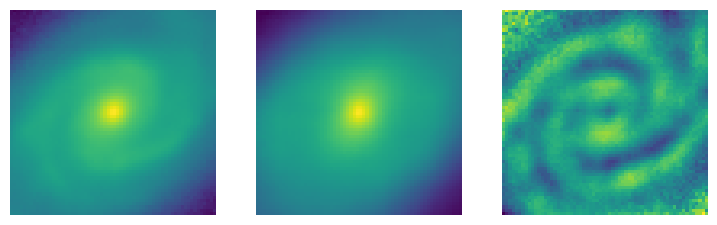

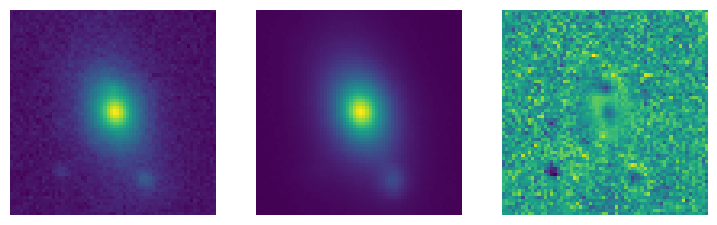

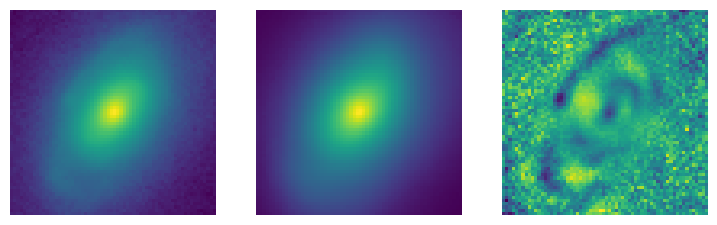

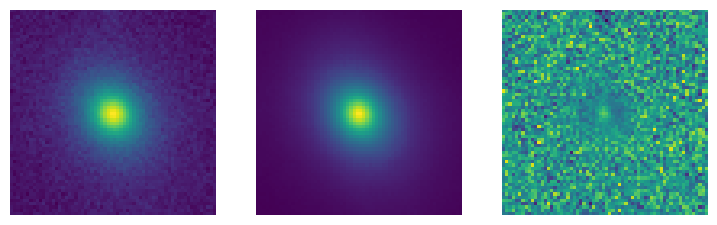

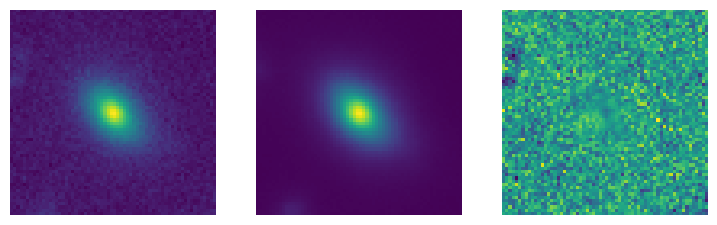

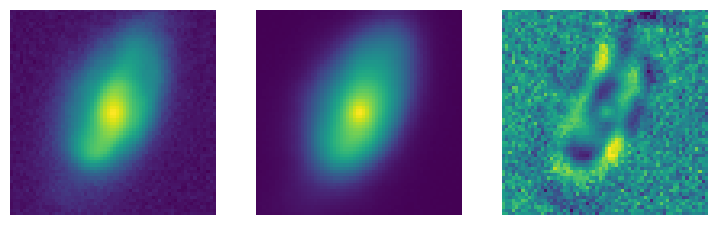

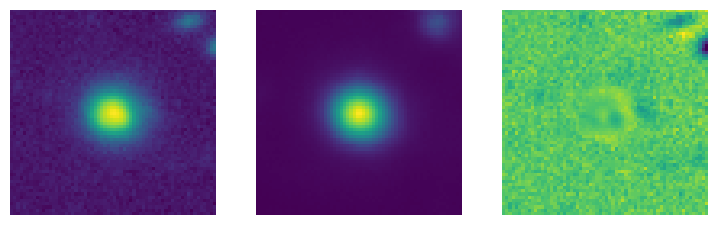

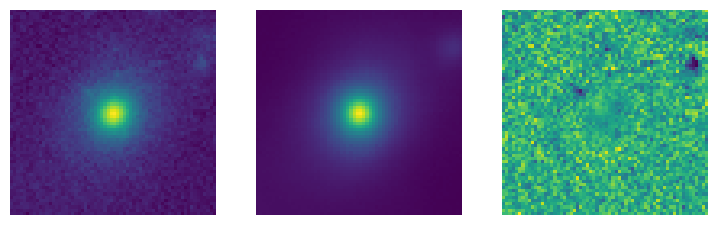

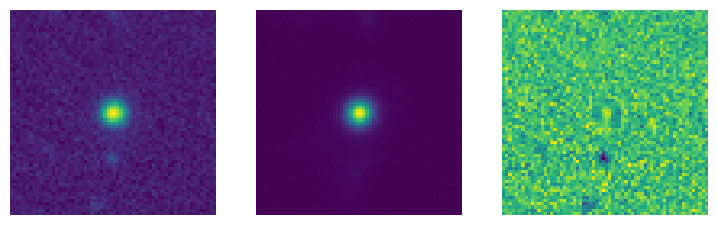

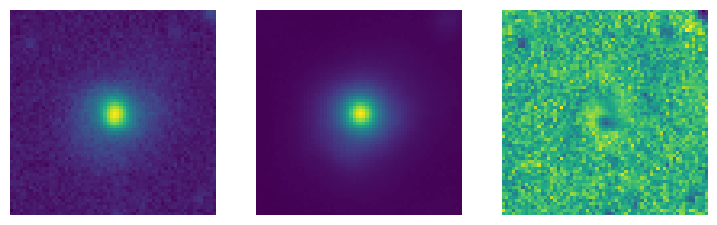

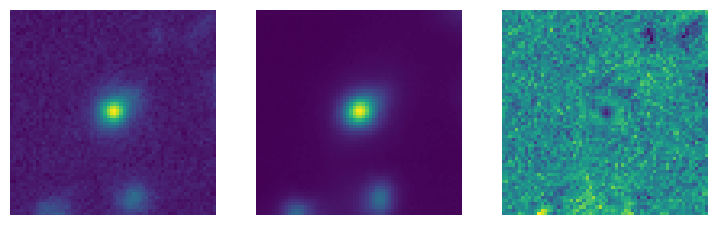

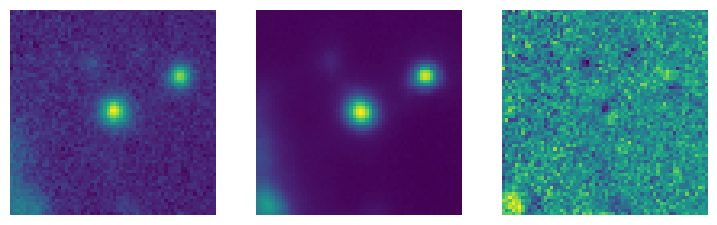

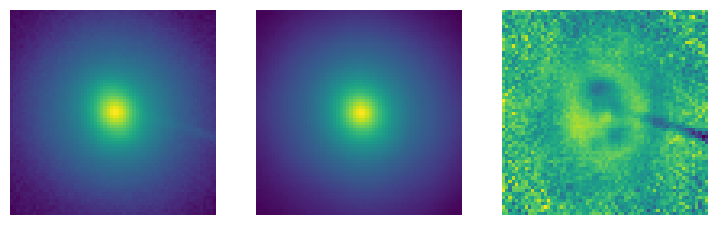

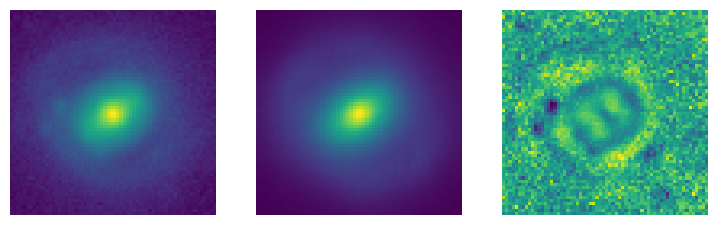

In [88]:
# Plotting the original and estimated image for 15 examples
plt.figure(figsize=(6,2));
for i in range(15):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,3));
    ax1.imshow(batch[i,:,:,:].mean(axis=-1))
    ax1.axis('off');
    ax2.imshow(z[i,:,:,:].mean(axis=-1))
    ax2.axis('off');
    ax3.imshow(z[i,:,:,:].mean(axis=-1) - batch[i,:,:,:].mean(axis=-1))
    ax3.axis('off');

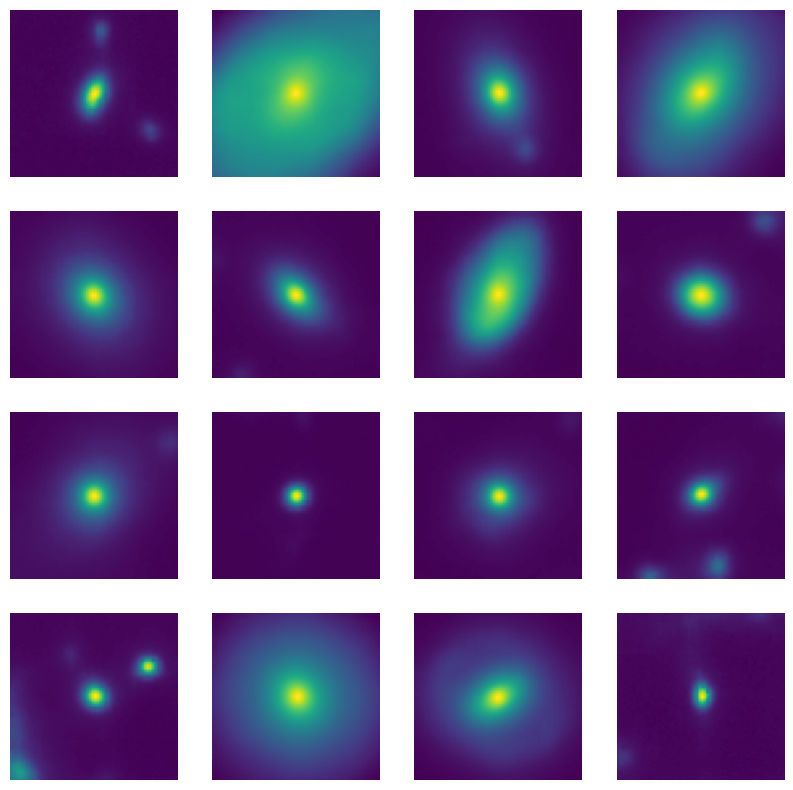

In [89]:
# 16 images of the estimated shape of galaxies
plt.figure(figsize=(10,10))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i+4*j+1)
        plt.imshow(z[i+4*j,:,:,:].mean(axis=-1))
        plt.axis('off');

In [ ]:
# # Let's store the dimensionality of our latent space
# d = 32

In [ ]:
# class AffineCoupling(nn.Module):

#     @nn.compact
#     def __call__(self, x, nunits):

#         net = nn.leaky_relu(nn.Dense(128)(x))
#         net = nn.leaky_relu(nn.Dense(128)(net))

#         # Shift and scale parameters
#         shift = nn.Dense(nunits)(net)
#         scale = nn.softplus(nn.Dense(nunits)(net)) + 1e-3 # For numerical stability

#         return  tfb.Chain([ tfb.Shift(shift), tfb.Scale(scale)])

In [ ]:
# def make_nvp_fn(n_layers=4, d=2):

#     # We alternate between permutations and flow layers
#     layers = [ tfb.Permute([1,0])(tfb.RealNVP(d//2, 
#                                             bijector_fn=AffineCoupling(name='affine%d'%i)))
#             for i in range(n_layers) ]

#     # We build the actual nvp from these bijectors and a standard Gaussian distribution
#     nvp = tfd.TransformedDistribution(
#               tfd.MultivariateNormalDiag(loc=jnp.zeros(2)),
#               bijector=tfb.Chain(layers))
#     return nvp

In [ ]:
# class NeuralSplineFlowLogProb(nn.Module):
#     @nn.compact
#     def __call__(self,  x):
#         nvp = make_nvp_fn()
#         return nvp.log_prob(x)

# class NeuralSplineFlowSampler(nn.Module):
#     @nn.compact
#     def __call__(self,  key, n_samples):
#         nvp = make_nvp_fn()
#         return nvp.sample(n_samples, seed=key)

In [ ]:
# model = NeuralSplineFlowLogProb()

# # Random seed for initializaing network and sampling training data
# seed = random.PRNGKey(42)

# # Initializes the weights of the model
# params = model.init(seed, jnp.zeros((1,d)))

# # Initializes an optimizer and optimizer state
# optimizer = optax.chain(
#       optax.adam(1e-4),
#       optax.scale_by_schedule(lr_schedule))

# opt_state = optimizer.init(params)